In [4]:
# Import necessary libraries
import pandas as pd
import plotly.graph_objs as go
import json
import re

# Function to read and parse the JSON Lines file
def read_experiment_data(file_path):
    data = []
    tasks_encountered = set()
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line)
            if 'mb_index' not in record:
                continue  # Skip records without mb_index
            mb_index = record['mb_index']
            row = {'mb_index': mb_index}
            # Extract Task000 from Top1_Acc_Stream
            stream_key = 'Top1_Acc_Stream/eval_phase/valid_stream/Task000'
            if stream_key in record:
                row['Task000'] = record[stream_key]
                tasks_encountered.add('Task000')
            # Extract Task001 to Task019 from Top1_Acc_Exp
            for key in record:
                if key.startswith('Top1_Acc_Exp/eval_phase/valid_stream/Task000/Exp'):
                    # Extract the experiment number
                    exp_num = int(re.search(r'Exp(\d{3})', key).group(1))
                    if exp_num >= 0:
                        task_id = f'Task{exp_num:03d}'
                        row[task_id] = record[key]
                        tasks_encountered.add(task_id)
            # Record the list of tasks encountered up to this point
            row['tasks_encountered'] = tasks_encountered.copy()
            data.append(row)
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Sort by mb_index
    df.sort_values('mb_index', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Paths to your JSON Lines files for the two experiments
experiment1_path = '/data/e.urettini/projects/CL_stability/ocl_survey/results/ema_split_cifar100_20_2000/0/logs_continual.json'  # Replace with your actual path
experiment2_path = '/data/e.urettini/projects/CL_stability/ocl_survey/results/er_ng_split_cifar100_20_2000_CAR/0/logs_continual.json'  # Replace with your actual path

# Read data from the two experiments
df1 = read_experiment_data(experiment1_path)
df2 = read_experiment_data(experiment2_path)

# Function to compute mean accuracy over encountered tasks at each time step
def compute_mean_accuracy(df):
    mean_accuracies = []
    for idx, row in df.iterrows():
        tasks = row['tasks_encountered']
        accuracies = row[list(tasks)]
        mean_acc = accuracies.mean()
        mean_accuracies.append(mean_acc)
    df['Mean'] = mean_accuracies
    return df

# Compute mean accuracies for both DataFrames
df1 = compute_mean_accuracy(df1)
df2 = compute_mean_accuracy(df2)

# Prepare the list of all possible tasks
all_tasks = sorted(set(df1.columns).union(df2.columns) - {'mb_index', 'tasks_encountered', 'Mean'})

# Plotting with Plotly
fig = go.Figure()

# Define colors for experiments
colors = {'Exp_1': 'blue', 'Exp_2': 'red'}

# Add traces for Manual experiment
for task in all_tasks:
    if task in df1.columns:
        fig.add_trace(go.Scatter(
            x=df1['mb_index'],
            y=df1[task],
            mode='lines',
            name=f'Exp_1 {task}',
            line=dict(color=colors['Exp_1']),
            legendgroup='Exp_1'
        ))

# Add mean trace for Exp_1 experiment
fig.add_trace(go.Scatter(
    x=df1['mb_index'],
    y=df1['Mean'],
    mode='lines',
    name='Exp_1 Mean',
    line=dict(color=colors['Exp_1'], width=2, dash='dot'),
    legendgroup='Exp_1'
))

# Add traces for Exp_2 experiment
for task in all_tasks:
    if task in df2.columns:
        fig.add_trace(go.Scatter(
            x=df2['mb_index'],
            y=df2[task],
            mode='lines',
            name=f'Exp_2 {task}',
            line=dict(color=colors['Exp_2']),
            legendgroup='Exp_2'
        ))

# Add mean trace for Exp_2 experiment
fig.add_trace(go.Scatter(
    x=df2['mb_index'],
    y=df2['Mean'],
    mode='lines',
    name='Exp_2 Mean',
    line=dict(color=colors['Exp_2'], width=2, dash='dot'),
    legendgroup='Exp_2'
))

# Update layout
fig.update_layout(
    title='Top1 Accuracy over Time for All Tasks',
    xaxis_title='mb_index',
    yaxis_title='Top1 Accuracy',
    legend_title='Experiments',
    template='plotly_white',
    height=600,
    width=1000
)

# Create buttons for dropdown menu
buttons = []

# All Tasks button
buttons.append(dict(
    label='All Tasks',
    method='update',
    args=[{'visible': [True] * len(fig.data)},
          {'title': 'Top1 Accuracy over Time for All Tasks'}]
))

# Individual Task buttons
for task in all_tasks:
    visibility = []
    for trace in fig.data:
        if task in trace.name or 'Mean' in trace.name:
            visibility.append(True)
        else:
            visibility.append(False)
    buttons.append(dict(
        label=task,
        method='update',
        args=[{'visible': visibility},
              {'title': f'Top1 Accuracy over Time - {task}'}]
    ))

# Mean Accuracy button
visibility = []
for trace in fig.data:
    if 'Mean' in trace.name:
        visibility.append(True)
    else:
        visibility.append(False)
buttons.append(dict(
    label='Mean',
    method='update',
    args=[{'visible': visibility},
          {'title': 'Mean Top1 Accuracy over Time'}]
))

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[dict(
        type='dropdown',
        buttons=buttons,
        direction='down',
        x=1.15,
        y=1,
        showactive=True,
        xanchor='left',
        yanchor='top'
    )]
)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html('top1_accuracy_over_time.html')




In [5]:
df1['Mean'].mean(), df2['Mean'].mean()

(0.37889330704482244, 0.4828977182219385)

<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_41845/2727716744.py:28: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Eigenvalue of F ($\lambda_i$)')
/tmp/ipykernel_41845/2727716744.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Effective Step Size ($\Delta \theta_i$)')


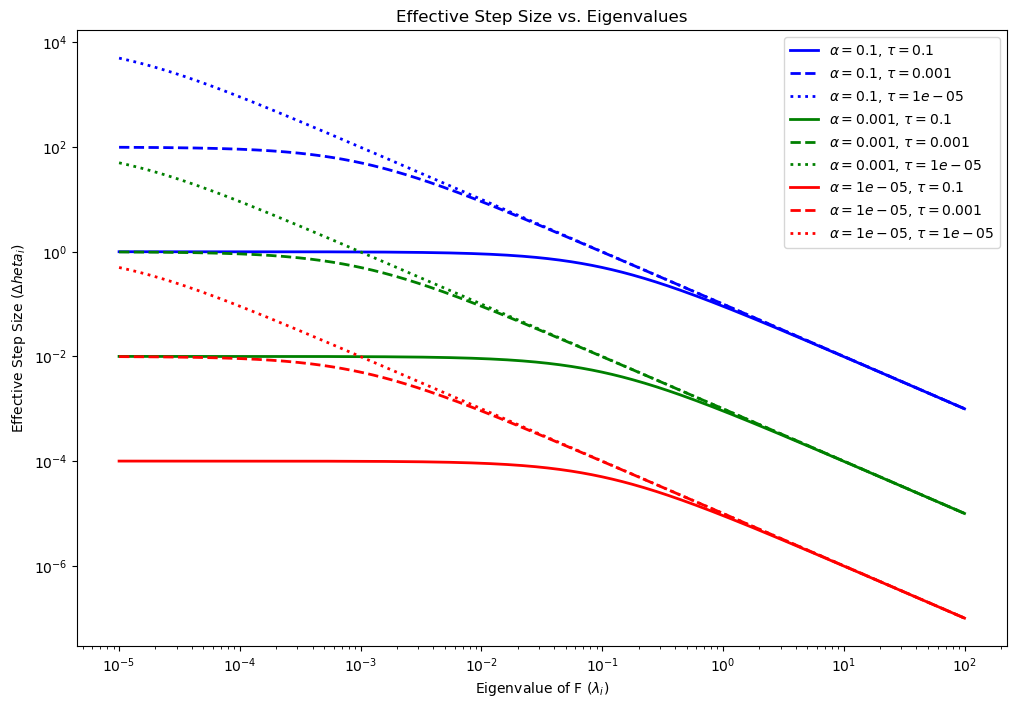

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of eigenvalues
lambdas = np.logspace(-5, 2, 500)

# Set learning rates and regularization parameters
alpha_values = [0.1, 0.001, 0.00001]
tau_values = [0.1, 0.001, 0.00001]

# Line colors for each alpha value
colors = ['blue', 'green', 'red']
# Line styles for each tau value
linestyles = ['-', '--', ':']

plt.figure(figsize=(12, 8))

for idx_alpha, alpha in enumerate(alpha_values):
    for idx_tau, tau in enumerate(tau_values):
        # Effective step size
        effective_lr = alpha / (lambdas + tau) 
        #Put alpha and tau as labels
        label = r'$\alpha={}$, $\tau={}$'.format(alpha, tau)
        plt.plot(lambdas, effective_lr, label=label, color=colors[idx_alpha], linestyle=linestyles[idx_tau], linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Eigenvalue of F ($\lambda_i$)')
plt.ylabel('Effective Step Size ($\Delta \theta_i$)')
plt.title('Effective Step Size vs. Eigenvalues')
plt.legend()
plt.show()



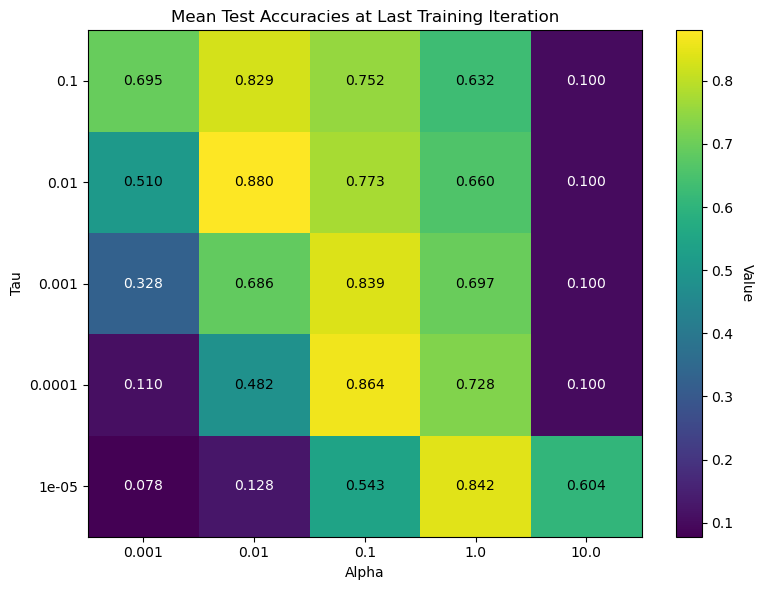

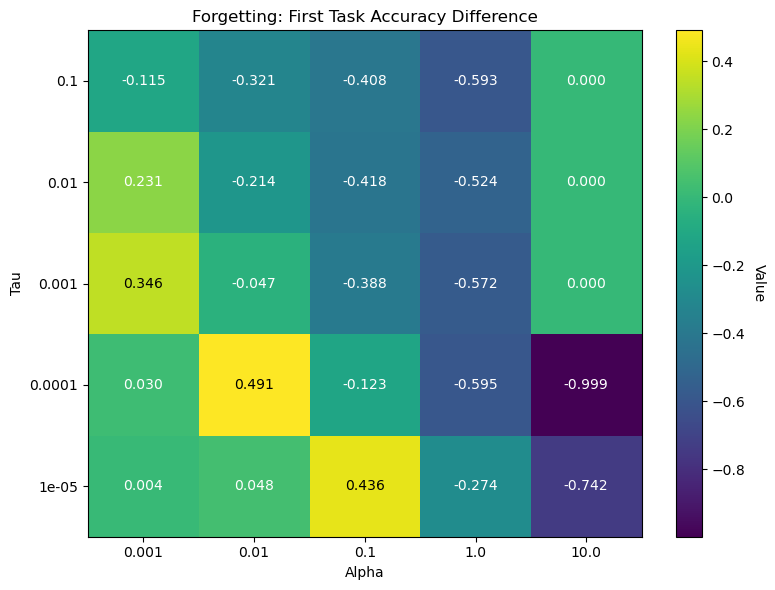

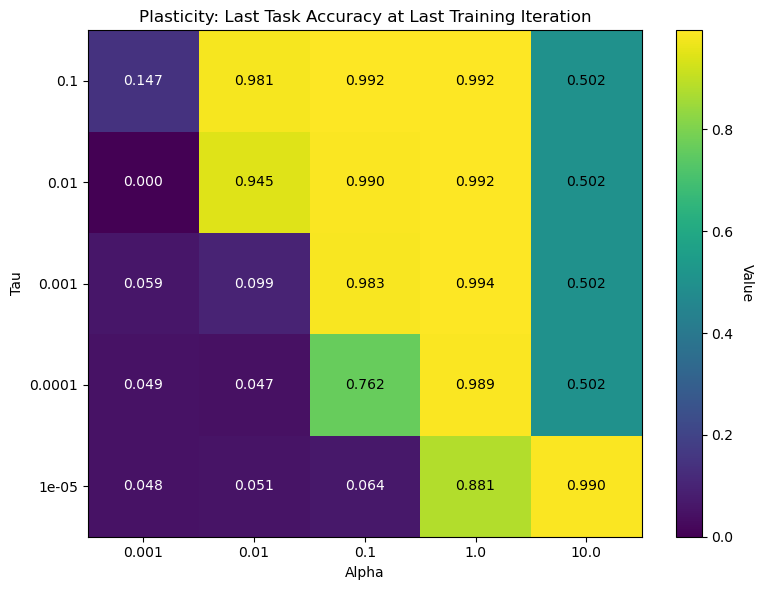

In [16]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    """
    Load data from a file containing a Python dictionary.

    Args:
        file_path (str): Path to the file.

    Returns:
        dict: Parsed Python dictionary with tuple keys.
    """
    with open(file_path, 'r') as file:
        content = file.read()
    data = ast.literal_eval(content)
    return data

def extract_parameters(data):
    """
    Extract and sort unique tau and alpha values from the data.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.

    Returns:
        list: Sorted unique tau values.
        list: Sorted unique alpha values.
    """
    taus = sorted({key[0] for key in data.keys()})
    alphas = sorted({key[1] for key in data.keys()})
    return taus, alphas

def compute_metrics(data, taus, alphas):
    """
    Compute the required metrics for each (tau, alpha) pair.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.
        taus (list): Sorted list of unique tau values.
        alphas (list): Sorted list of unique alpha values.

    Returns:
        pd.DataFrame: Mean test accuracies.
        pd.DataFrame: Forgetting metrics.
        pd.DataFrame: Plasticity metrics.
    """
    mean_test_acc = pd.DataFrame(index=taus, columns=alphas, dtype=float)
    forgetting = pd.DataFrame(index=taus, columns=alphas, dtype=float)
    plasticity = pd.DataFrame(index=taus, columns=alphas, dtype=float)
    
    for tau in taus:
        for alpha in alphas:
            key = (tau, alpha)
            entry = data[key]
            test_acc = entry['test/Accuracy']
            train_acc = entry['train/Accuracy']
            
            # Mean Test Accuracy at Last Training Iteration
            last_test = test_acc[-1]
            mean_test = np.mean(last_test)
            mean_test_acc.loc[tau, alpha] = mean_test
            
            # Forgetting: Difference in First Task Accuracy
            forgetting_diff = test_acc[-1][0] - test_acc[0][0]
            forgetting.loc[tau, alpha] = forgetting_diff
            
            # Plasticity: Last Task Accuracy at Last Training Iteration
            plasticity_val = test_acc[-1][-1]
            plasticity.loc[tau, alpha] = plasticity_val
    
    return mean_test_acc, forgetting, plasticity

def plot_heatmap(dataframe, title, xlabel, ylabel):
    """
    Plot an annotated heatmap using matplotlib.

    Args:
        dataframe (pd.DataFrame): Data to plot.
        title (str): Title of the plot.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(dataframe, cmap='viridis', aspect='auto', origin='lower')

    # Set ticks and labels
    plt.xticks(ticks=np.arange(len(dataframe.columns)), labels=dataframe.columns)
    plt.yticks(ticks=np.arange(len(dataframe.index)), labels=dataframe.index)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Value', rotation=270, labelpad=15)
    
    # Annotate each cell with its value
    for i in range(len(dataframe.index)):
        for j in range(len(dataframe.columns)):
            value = dataframe.iloc[i, j]
            plt.text(j, i, f"{value:.3f}", ha='center', va='center', color='w' if value < dataframe.values.max()/2 else 'black')
    
    # Labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def main():
    # Path to your data file
    file_path = '/data/e.urettini/projects/CL_stability/aa.json'  # Replace with your actual file path
    
    # Load data
    data = load_data(file_path)
    
    # Extract unique tau and alpha values
    taus, alphas = extract_parameters(data)
    
    # Compute metrics
    mean_test_acc, forgetting, plasticity = compute_metrics(data, taus, alphas)
    
    # Plot Mean Test Accuracies
    plot_heatmap(
        dataframe=mean_test_acc,
        title='Mean Test Accuracies at Last Training Iteration',
        xlabel='Alpha',
        ylabel='Tau'
    )
    
    # Plot Forgetting Metrics
    plot_heatmap(
        dataframe=forgetting,
        title='Forgetting: First Task Accuracy Difference',
        xlabel='Alpha',
        ylabel='Tau'
    )
    
    # Plot Plasticity Metrics
    plot_heatmap(
        dataframe=plasticity,
        title='Plasticity: Last Task Accuracy at Last Training Iteration',
        xlabel='Alpha',
        ylabel='Tau'
    )

if __name__ == "__main__":
    main()


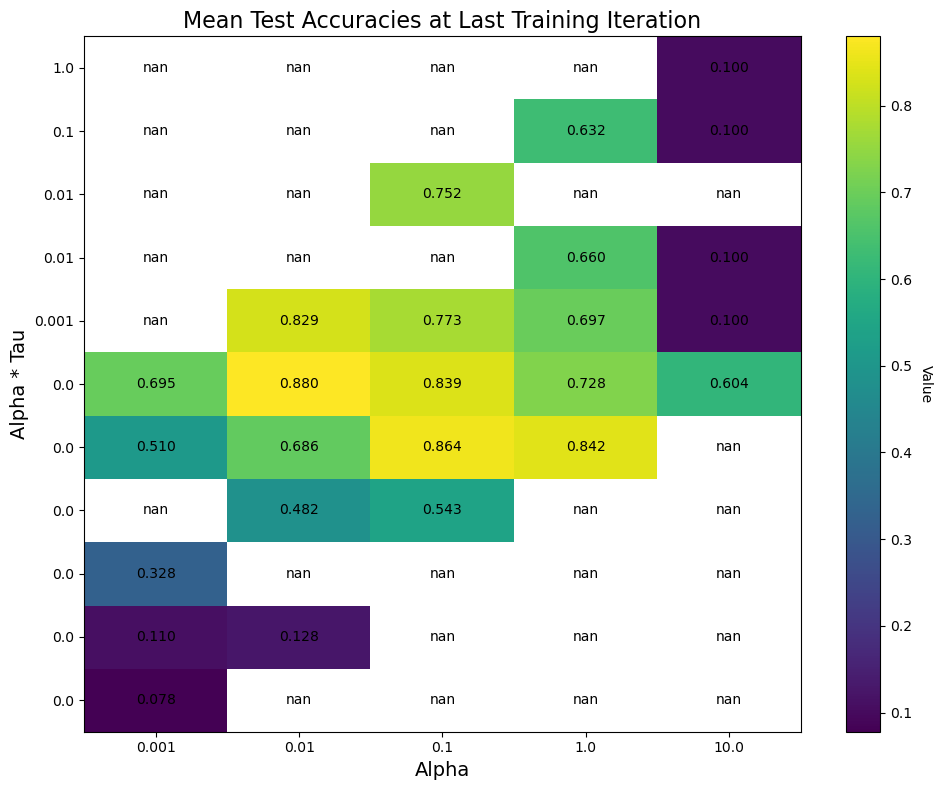

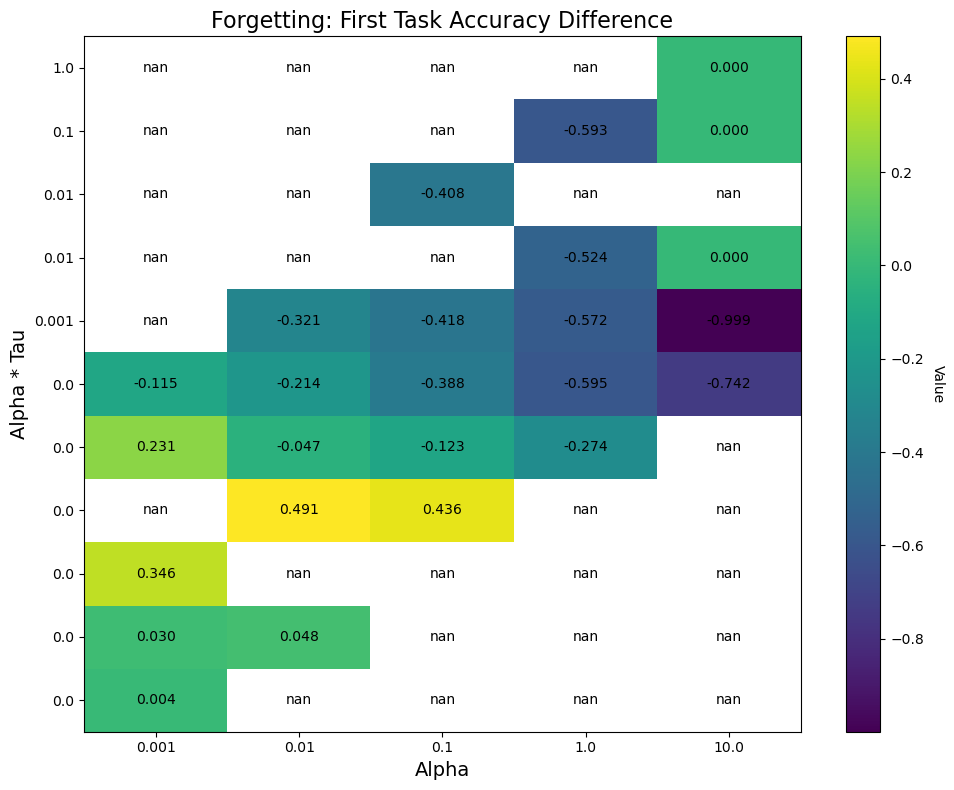

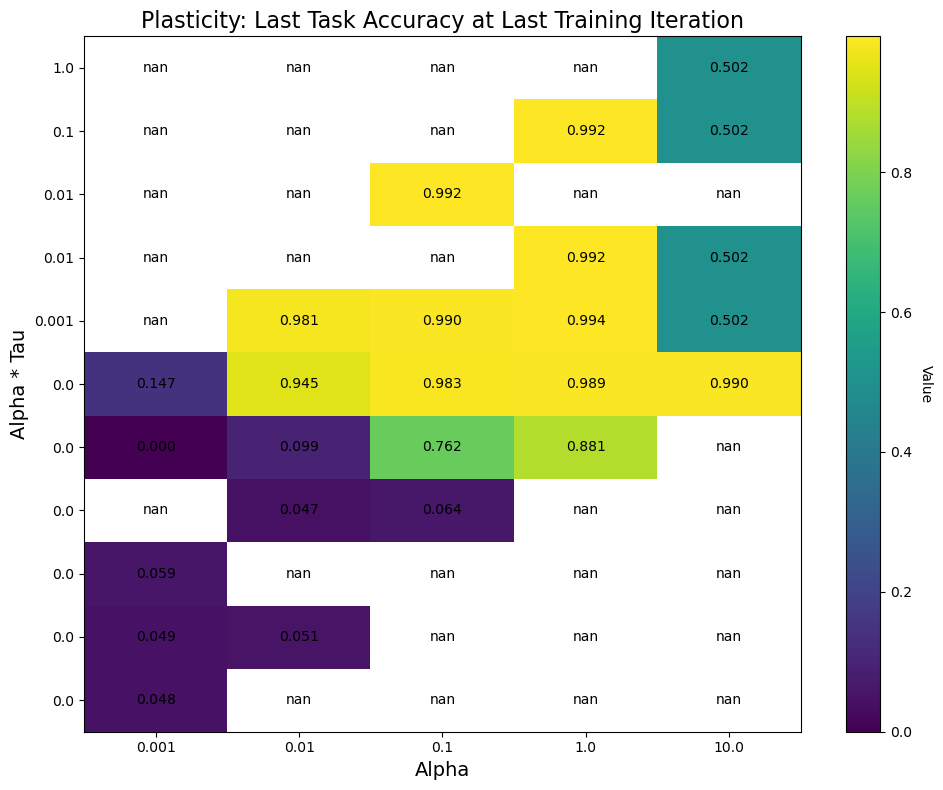

In [27]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    """
    Load data from a file containing a Python dictionary.

    Args:
        file_path (str): Path to the file.

    Returns:
        dict: Parsed Python dictionary with tuple keys.
    """
    with open(file_path, 'r') as file:
        content = file.read()
    data = ast.literal_eval(content)
    return data

def extract_parameters(data):
    """
    Extract and sort unique tau and alpha values from the data.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.

    Returns:
        list: Sorted unique tau values.
        list: Sorted unique alpha values.
    """
    taus = sorted({key[0] for key in data.keys()})
    alphas = sorted({key[1] for key in data.keys()})
    return taus, alphas

def compute_metrics_with_product(data, taus, alphas):
    """
    Compute the required metrics for each (tau, alpha) pair and calculate alpha*tau.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.
        taus (list): Sorted list of unique tau values.
        alphas (list): Sorted list of unique alpha values.

    Returns:
        pd.DataFrame: Mean test accuracies indexed by alpha*tau and columns alpha.
        pd.DataFrame: Forgetting metrics indexed by alpha*tau and columns alpha.
        pd.DataFrame: Plasticity metrics indexed by alpha*tau and columns alpha.
    """
    # Initialize empty lists to store the data
    records = []

    for tau in taus:
        for alpha in alphas:
            key = (tau, alpha)
            entry = data[key]
            test_acc = entry['test/Accuracy']
            train_acc = entry['train/Accuracy']
            
            # Mean Test Accuracy at Last Training Iteration
            last_test = test_acc[-1]
            mean_test = np.mean(last_test)
            
            # Forgetting: Difference in First Task Accuracy
            forgetting_diff = test_acc[-1][0] - test_acc[0][0]
            
            # Plasticity: Last Task Accuracy at Last Training Iteration
            plasticity_val = test_acc[-1][-1]
            
            # Compute y-axis value as alpha * tau
            y_value = alpha * tau
            
            records.append({
                'y': y_value,
                'alpha': alpha,
                'mean_test_acc': mean_test,
                'forgetting': forgetting_diff,
                'plasticity': plasticity_val
            })
    
    # Create a DataFrame from the records
    df = pd.DataFrame(records)
    
    # Sort the DataFrame by y to arrange the heatmap rows
    df_sorted = df.sort_values(by=['alpha', 'y']).reset_index(drop=True)
    
    # Create pivot tables for each metric
    mean_test_acc = df_sorted.pivot(index='y', columns='alpha', values='mean_test_acc')
    forgetting = df_sorted.pivot(index='y', columns='alpha', values='forgetting')
    plasticity = df_sorted.pivot(index='y', columns='alpha', values='plasticity')
    
    return mean_test_acc, forgetting, plasticity

def plot_heatmap(dataframe, title, xlabel, ylabel):
    """
    Plot an annotated heatmap using matplotlib.

    Args:
        dataframe (pd.DataFrame): Data to plot.
        title (str): Title of the plot.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
    """
    plt.figure(figsize=(10, 8))
    im = plt.imshow(dataframe, cmap='viridis', aspect='auto', origin='lower')

    # Set ticks and labels
    plt.xticks(ticks=np.arange(len(dataframe.columns)), labels=dataframe.columns)
    plt.yticks(ticks=np.arange(len(dataframe.index)), labels=np.round(dataframe.index, 3))

    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Value', rotation=270, labelpad=15)

    # Annotate each cell with its value
    for i in range(len(dataframe.index)):
        for j in range(len(dataframe.columns)):
            value = dataframe.iloc[i, j]
            plt.text(j, i, f"{value:.3f}", ha='center', va='center', color='w' if value < dataframe.values.max()/2 else 'black')

    # Labels and title
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tight_layout()
    plt.show()

def main():
    # Path to your data file
    file_path = '/data/e.urettini/projects/CL_stability/aa.json'  # Replace with your actual file path
    
    # Load data
    data = load_data(file_path)
    
    # Extract unique tau and alpha values
    taus, alphas = extract_parameters(data)
    
    # Compute metrics and y = alpha * tau
    mean_test_acc, forgetting, plasticity = compute_metrics_with_product(data, taus, alphas)
    
    # Sort the y-axis in ascending order for better visualization
    mean_test_acc_sorted = mean_test_acc.sort_index()
    forgetting_sorted = forgetting.sort_index()
    plasticity_sorted = plasticity.sort_index()
    
    # Plot Mean Test Accuracies
    plot_heatmap(
        dataframe=mean_test_acc_sorted,
        title='Mean Test Accuracies at Last Training Iteration',
        xlabel='Alpha',
        ylabel='Alpha * Tau'
    )
    
    # Plot Forgetting Metrics
    plot_heatmap(
        dataframe=forgetting_sorted,
        title='Forgetting: First Task Accuracy Difference',
        xlabel='Alpha',
        ylabel='Alpha * Tau'
    )
    
    # Plot Plasticity Metrics
    plot_heatmap(
        dataframe=plasticity_sorted,
        title='Plasticity: Last Task Accuracy at Last Training Iteration',
        xlabel='Alpha',
        ylabel='Alpha * Tau'
    )

if __name__ == "__main__":
    main()




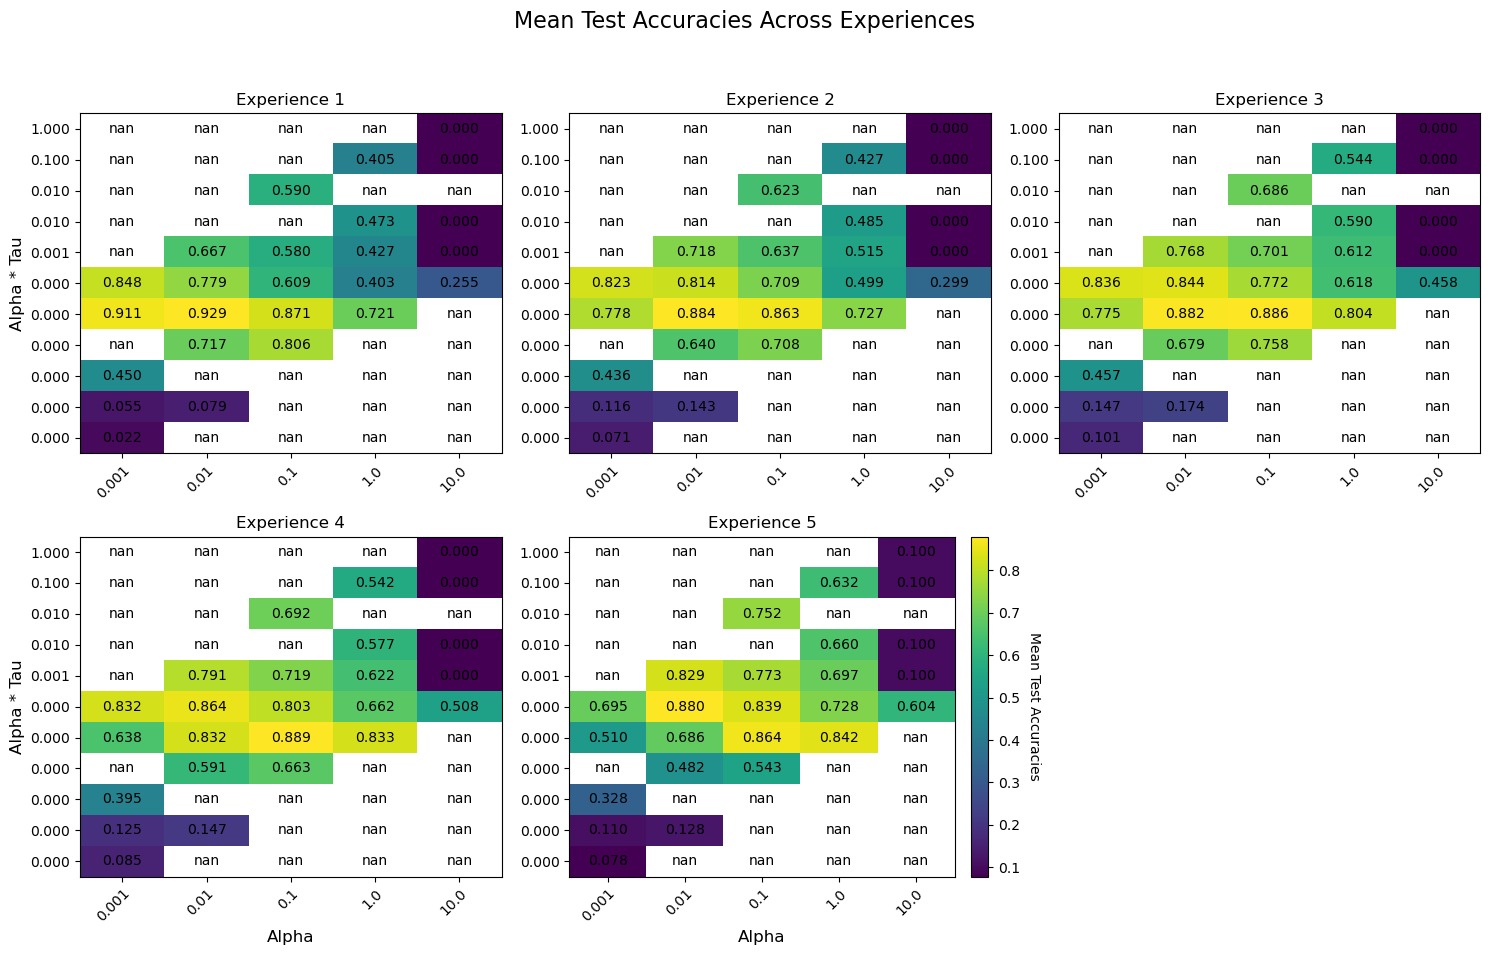

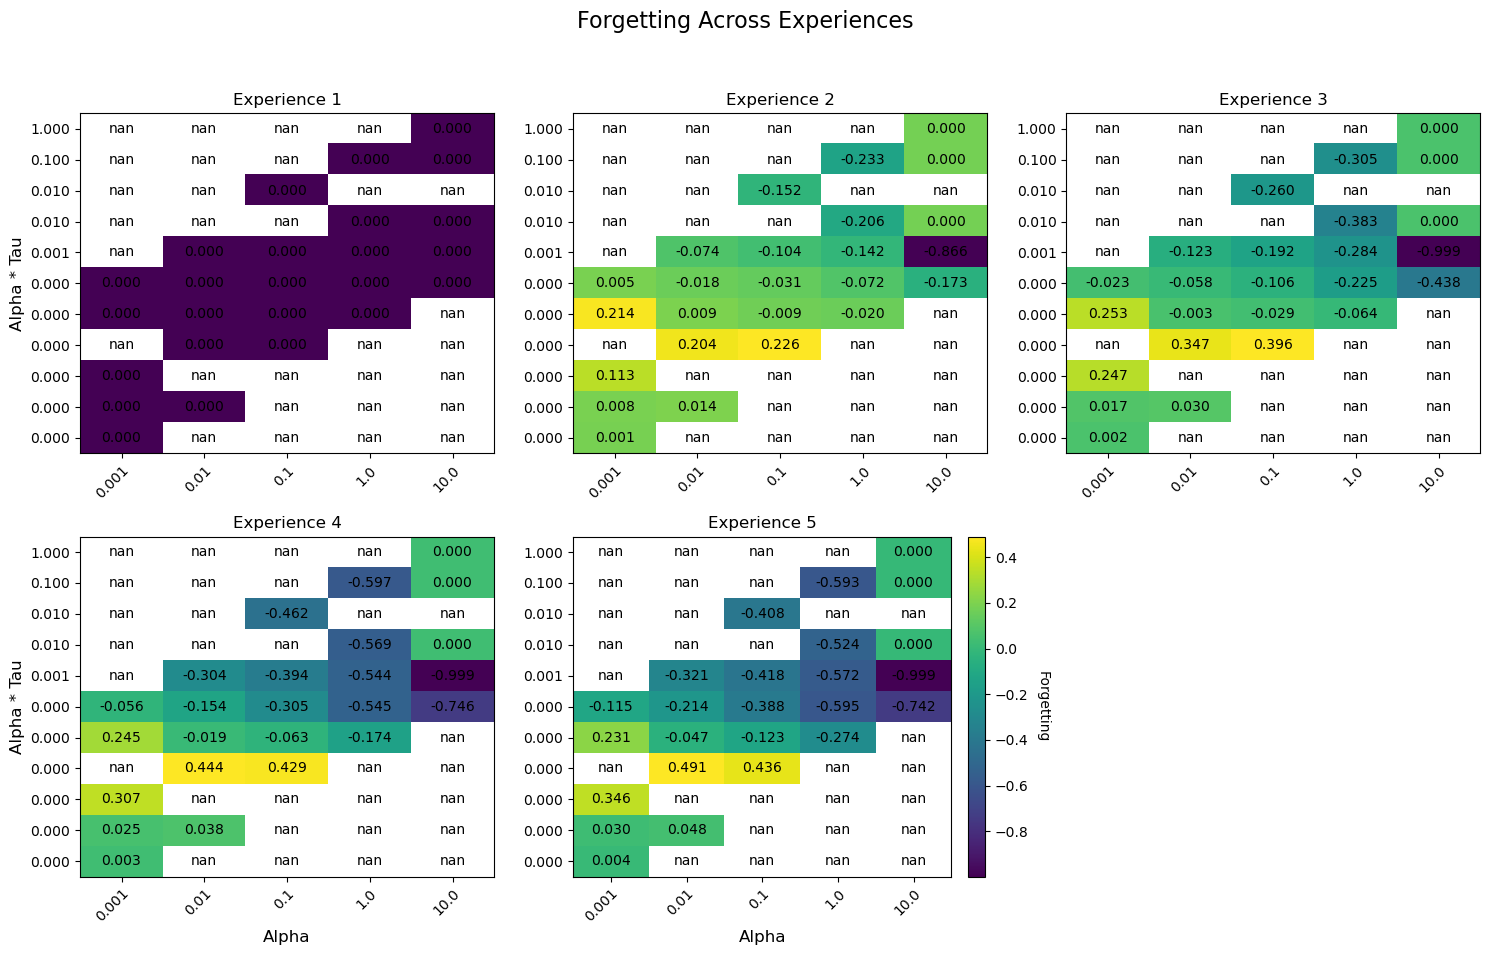

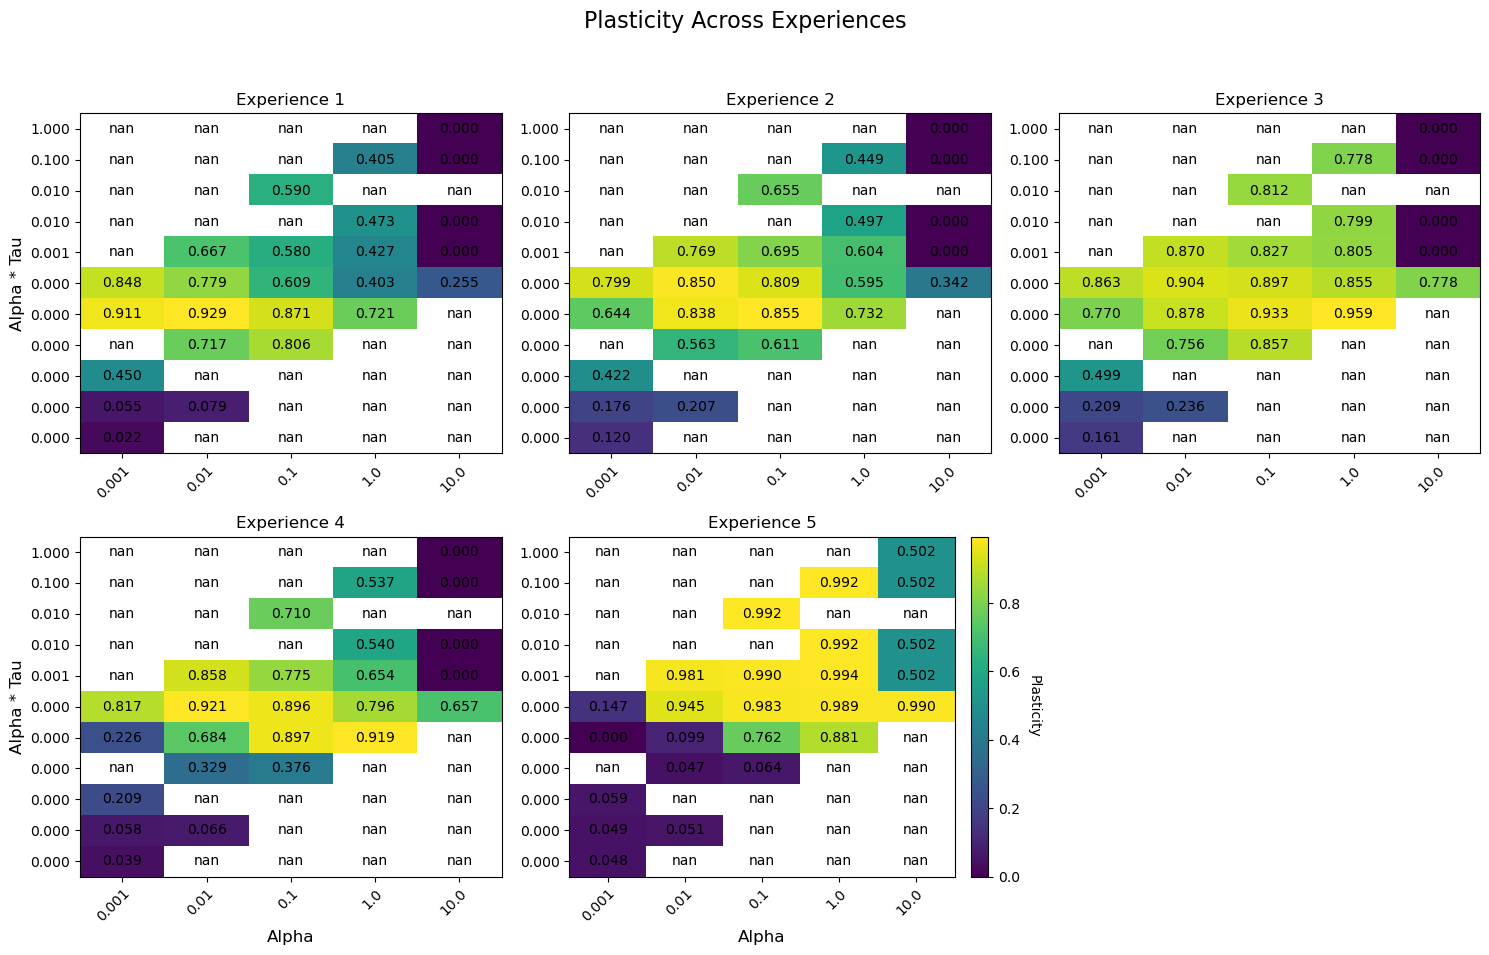

In [31]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    """
    Load data from a file containing a Python dictionary.

    Args:
        file_path (str): Path to the file.

    Returns:
        dict: Parsed Python dictionary with tuple keys.
    """
    with open(file_path, 'r') as file:
        content = file.read()
    data = ast.literal_eval(content)
    return data

def extract_parameters(data):
    """
    Extract and sort unique tau and alpha values from the data.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.

    Returns:
        list: Sorted unique tau values.
        list: Sorted unique alpha values.
    """
    taus = sorted({key[0] for key in data.keys()})
    alphas = sorted({key[1] for key in data.keys()})
    return taus, alphas

def compute_cumulative_metrics(data, taus, alphas, num_experiences):
    """
    Compute cumulative mean test accuracies, forgetting, and plasticity for each (tau, alpha) pair up to each experience.

    Args:
        data (dict): Parsed Python dictionary with tuple keys.
        taus (list): Sorted list of unique tau values.
        alphas (list): Sorted list of unique alpha values.
        num_experiences (int): Number of experiences (tasks).

    Returns:
        list of pd.DataFrame: List containing DataFrames for each experience's mean test accuracy.
        list of pd.DataFrame: List containing DataFrames for each experience's forgetting.
        list of pd.DataFrame: List containing DataFrames for each experience's plasticity.
    """
    mean_test_acc_list = []
    forgetting_list = []
    plasticity_list = []

    for e in range(1, num_experiences + 1):
        mean_records = []
        forgetting_records = []
        plasticity_records = []

        for tau in taus:
            for alpha in alphas:
                key = (tau, alpha)
                entry = data[key]
                test_acc = entry['test/Accuracy']
                train_acc = entry['train/Accuracy']

                # Compute y-axis value as alpha * tau
                y_value = alpha * tau

                # 1. Mean Test Accuracy: Average of first 'e' tasks at the last training iteration
                selected_test_acc = test_acc[-1][:e]
                mean_test = np.mean(selected_test_acc)
                mean_records.append({'y': y_value, 'alpha': alpha, 'mean_test_acc': mean_test})

                # 2. Forgetting: Difference in first task's accuracy between current and first experience
                forgetting_diff = test_acc[e-1][0] - test_acc[0][0]
                forgetting_records.append({'y': y_value, 'alpha': alpha, 'forgetting': forgetting_diff})

                # 3. Plasticity: Accuracy of the task just learned in the current experience
                # For experience e, the task just learned is the e-th task (0-based index: e-1)
                plasticity_val = test_acc[-1][e-1]
                plasticity_records.append({'y': y_value, 'alpha': alpha, 'plasticity': plasticity_val})

        # Create DataFrames
        mean_df = pd.DataFrame(mean_records).pivot(index='y', columns='alpha', values='mean_test_acc').sort_index()
        forgetting_df = pd.DataFrame(forgetting_records).pivot(index='y', columns='alpha', values='forgetting').sort_index()
        plasticity_df = pd.DataFrame(plasticity_records).pivot(index='y', columns='alpha', values='plasticity').sort_index()

        mean_test_acc_list.append(mean_df)
        forgetting_list.append(forgetting_df)
        plasticity_list.append(plasticity_df)

    return mean_test_acc_list, forgetting_list, plasticity_list

def plot_cumulative_heatmaps(cumulative_mean_list, cumulative_forgetting_list, cumulative_plasticity_list, alphas, num_experiences):
    """
    Plot cumulative mean test accuracies, forgetting, and plasticity as heatmaps for each experience.

    Args:
        cumulative_mean_list (list of pd.DataFrame): List of DataFrames for mean test accuracies.
        cumulative_forgetting_list (list of pd.DataFrame): List of DataFrames for forgetting.
        cumulative_plasticity_list (list of pd.DataFrame): List of DataFrames for plasticity.
        alphas (list): Sorted list of alpha values.
        num_experiences (int): Number of experiences (tasks).
    """
    # Define the metrics and their corresponding data lists
    metrics = {
        'Mean Test Accuracies': cumulative_mean_list,
        'Forgetting': cumulative_forgetting_list,
        'Plasticity': cumulative_plasticity_list
    }

    for metric_name, metric_list in metrics.items():
        # Determine subplot grid size
        cols = 3  # Adjust based on preference
        rows = (num_experiences + cols - 1) // cols  # Ceiling division

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten()  # Flatten in case of multiple rows

        for idx, pivot_df in enumerate(metric_list):
            ax = axes[idx]
            im = ax.imshow(pivot_df, cmap='viridis', aspect='auto', origin='lower')

            # Set ticks and labels
            ax.set_xticks(np.arange(len(alphas)))
            ax.set_xticklabels(alphas)
            y_labels = [f"{val:.3f}" for val in pivot_df.index]
            ax.set_yticks(np.arange(len(pivot_df.index)))
            ax.set_yticklabels(y_labels)

            # Rotate the tick labels and set alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

            # Annotate each cell with the metric value
            for i in range(len(pivot_df.index)):
                for j in range(len(pivot_df.columns)):
                    value = pivot_df.iloc[i, j]
                    ax.text(j, i, f"{value:.3f}", ha='center', va='center',
                            color='white' if value < pivot_df.values.max()/2 else 'black')

            # Title for each subplot
            ax.set_title(f'Experience {idx + 1}')

            # Labels
            if idx % cols == 0:
                ax.set_ylabel('Alpha * Tau', fontsize=12)
            if idx >= (rows - 1) * cols:
                ax.set_xlabel('Alpha', fontsize=12)

            # Add colorbar to the last subplot
            if idx == num_experiences - 1:
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel(metric_name, rotation=270, labelpad=15)

        # Hide any unused subplots
        for idx in range(num_experiences, len(axes)):
            fig.delaxes(axes[idx])

        plt.suptitle(f'{metric_name} Across Experiences', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the super title
        plt.show()

def main():
    # Path to your data file
    file_path = '/data/e.urettini/projects/CL_stability/aa.json'  # Replace with your actual file path

    # Load data
    data = load_data(file_path)

    # Extract unique tau and alpha values
    taus, alphas = extract_parameters(data)

    # Determine the number of experiences (tasks)
    # Assuming all (tau, alpha) pairs have the same number of experiences
    sample_key = next(iter(data))
    num_experiences = len(data[sample_key]['train/Accuracy'][0])  # Number of tasks per experience

    # Compute cumulative metrics
    mean_test_acc_list, forgetting_list, plasticity_list = compute_cumulative_metrics(data, taus, alphas, num_experiences)

    # Plot heatmaps for each metric
    plot_cumulative_heatmaps(mean_test_acc_list, forgetting_list, plasticity_list, alphas, num_experiences)

if __name__ == "__main__":
    main()




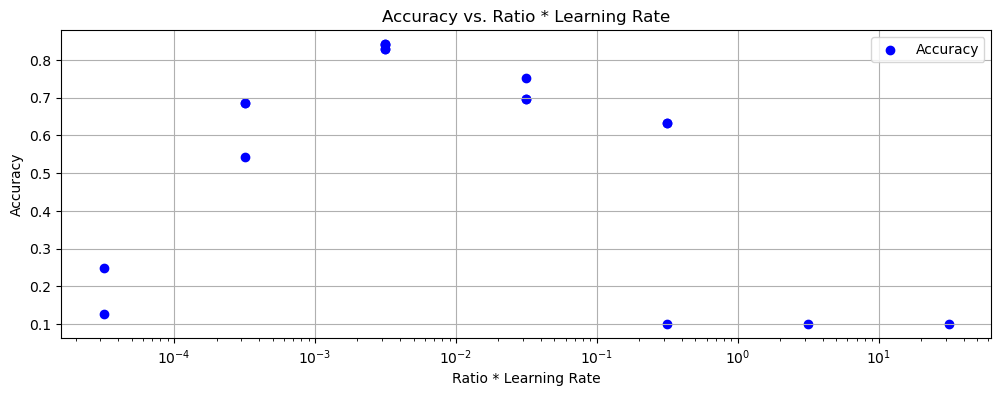

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define learning rate and regularization values
lr_values = np.array([0.1, 0.001, 1e-5])
regul_values = np.array([0.1, 0.001, 1e-5])

# Values extracted from the "Grid Without Rescaling (Joint)" plot
accuracy_joint = np.array([[0.632, 0.829, 0.248],
                           [0.100, 0.697, 0.686],
                           [0.100, 0.100, 0.842]])

# Create a DataFrame with corresponding lr and regul values
df_joint = pd.DataFrame({
    'lr': np.tile(lr_values, 3),
    'regul': np.repeat(regul_values, 3),
    'accuracy': accuracy_joint.flatten()
})

# Define learning rate and regularization values for the rescaled grid
lr_values_rescaled = np.array([0.01, 0.1, 1])
regul_values = np.array([1e-5, 0.001, 0.1])

# Accuracy values extracted from the "Grid with LR Rescaling (Joint)" plot
accuracy_joint_rescaled = np.array([[0.128, 0.543, 0.842],
                                    [0.686, 0.839, 0.697],
                                    [0.829, 0.752, 0.632]])

# Create a DataFrame with corresponding lr and regul values
df_joint_rescaled = pd.DataFrame({
    'lr': np.tile(lr_values_rescaled, 3),
    'regul': np.repeat(regul_values, 3),
    'accuracy': accuracy_joint_rescaled.flatten()
})


#Transform lr by multiplying by regul
df_joint_rescaled['lr'] = df_joint_rescaled['lr'] * df_joint_rescaled['regul']

#Concatenate the two DataFrames
df = pd.concat([df_joint, df_joint_rescaled])

# Add a column ratio (lr/regul) and a column ratio*lr
df['ratio'] = df['lr'] / df['regul']
df['ratio_mod'] = df['lr'] / np.sqrt(df['regul'])

#Plot the values of accuracy as a function of ratio*lr with the x-axis on a log scale
#Do not do any grouping for the lr values
plt.figure(figsize=(12, 4))
plt.scatter(df['ratio_mod'], df['accuracy'], c='b', label='Accuracy')
plt.xscale('log')
plt.xlabel('Ratio * Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Ratio * Learning Rate')
plt.legend()
plt.grid(True)
plt.show()




    



